In [1]:
import os
from tqdm import tqdm

import math
import numpy as np

import cv2

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from pytorch_grad_cam.utils.image import show_cam_on_image

from src.dataset import DogVSCatObjectDetectionDataset
from src.models import create_fasterrcnn_mobilenet_v3_large_model
from src.utils import imshow_with_box
from src.prediction import predict, predict_single_image

from src.explainers.FasterRCNN_GradCAM import FasterRCNN_GradCAM
from src.explainers.FasterRCNN_EigenCAM import FasterRCNN_EigenCAM
from src.explainers.D_RISE import D_RISE
from src.explainers.LIME import LIME

from src.metrics.deletion import Deletion

import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "./data/"
TRAIN_FOLDER = 'train_artifacts/'
TEST_FOLDER = 'test_artifacts/'
IMAGES_FOLDER = "images/"
ANNOTATIONS_FOLDER = "annotations/"

# MODEL_PATH = "./models/Faster_RCNN_mobilenet_v3.pt"  # .pt or .pth
MODEL_PATH = './models/Artifacts_Faster_RCNN_mobilenet_v3.pt'

LABELS_TO_IDX = {"background": 0, "cat": 1, "dog": 2}
NUMBER_CLASSES = len(LABELS_TO_IDX)

TRANSFORM = transforms.Compose([transforms.ToTensor()])

BATCH_SIZE = 4
# NUM_WORKERS = 1
EPOCHS = 5

D_RISE_REPETITION = 10 # 5000
LIME_REPETITION = 10 # 1000

DEVICE = 'cpu'

In [3]:
train_dataset = DogVSCatObjectDetectionDataset(
    images_path=os.path.join(DATA_PATH, TRAIN_FOLDER, IMAGES_FOLDER),
    annotations_path=os.path.join(DATA_PATH, TRAIN_FOLDER, ANNOTATIONS_FOLDER),
    class_to_idx_mapping=LABELS_TO_IDX,
    transform=TRANSFORM,
)

test_dataset = DogVSCatObjectDetectionDataset(
    images_path=os.path.join(DATA_PATH, TEST_FOLDER, IMAGES_FOLDER),
    annotations_path=os.path.join(DATA_PATH, TEST_FOLDER, ANNOTATIONS_FOLDER),
    class_to_idx_mapping=LABELS_TO_IDX,
    transform=TRANSFORM,
)

In [4]:
model = create_fasterrcnn_mobilenet_v3_large_model(NUMBER_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

# Explanations

In [5]:
# Image
img, targets = test_dataset[np.random.randint(0, len(test_dataset))]
# img, targets = test_dataset[10]

# Prediction
pred = predict_single_image(model, img, prediction_confidence=0.5, use_nms=True, iou_threshold=0.1, device=DEVICE)

In [6]:
# train_dataset = DogVSCatObjectDetectionDataset(
#     images_path=os.path.join('./data/train/', IMAGES_FOLDER),
#     annotations_path=os.path.join('./data/train/', ANNOTATIONS_FOLDER),
#     class_to_idx_mapping=LABELS_TO_IDX,
#     transform=TRANSFORM,
# )

# test_dataset = DogVSCatObjectDetectionDataset(
#     images_path=os.path.join('./data/test/', IMAGES_FOLDER),
#     annotations_path=os.path.join('./data/test/', ANNOTATIONS_FOLDER),
#     class_to_idx_mapping=LABELS_TO_IDX,
#     transform=TRANSFORM,
# )

In [7]:
# # Image
# img, targets = test_dataset[np.random.randint(0, len(test_dataset))]
# # img, targets = test_dataset[10]

# # Prediction
# pred = predict_single_image(model, img, prediction_confidence=0.5, use_nms=True, iou_threshold=0.1, device=DEVICE)
# pred

In [8]:
# GradCAM
gradCam = FasterRCNN_GradCAM(model, model.backbone)

grayscale_gradcam = gradCam.generate_saliency_map(image=img)

gradcam_image = show_cam_on_image(torch.permute(img, (1, 2, 0)).numpy(), grayscale_gradcam, use_rgb=True)

/Users/diogo/miniforge3/envs/tese_env/lib/python3.9/site-packages/torch/nn/modules/module.py:1082: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "


In [9]:
# EigenCAM
eigenCam = FasterRCNN_EigenCAM(model=model)

grayscale_cam = eigenCam.generate_saliency_map(image=img, target_label=pred['labels'], target_box=pred['boxes'])

eigencam_image = show_cam_on_image(np.moveaxis(img.numpy(), 0, 2), grayscale_cam, use_rgb=True)

In [10]:
# D-RISE
d_rise = D_RISE(model=model, device=DEVICE)

d_rise_cam = d_rise.generate_saliency_map(
    image=img,
    target_label=pred['labels'][0].item(),
    target_box=pred['boxes'][0],
    nr_iterations=D_RISE_REPETITION
)

d_rise_image = show_cam_on_image(torch.permute(img, (1, 2, 0)).numpy(), d_rise_cam, use_rgb=True)

100%|██████████| 1/1 [00:04<00:00,  4.31s/it]


In [11]:
# LIME
lime = LIME(model=model, device=DEVICE)

lime_cam = lime.generate_saliency_map(
    image=img,
    target_label=pred['labels'][0].item(),
    target_box=pred['boxes'][0],
    n_samples=LIME_REPETITION,
    super_pixel_size=25,
    show_progress=True,
)

lime_image = show_cam_on_image(torch.permute(img, (1, 2, 0)).numpy(), lime_cam, use_rgb=True)

Lime attribution:   0%|          | 0/10 [00:00<?, ?it/s]

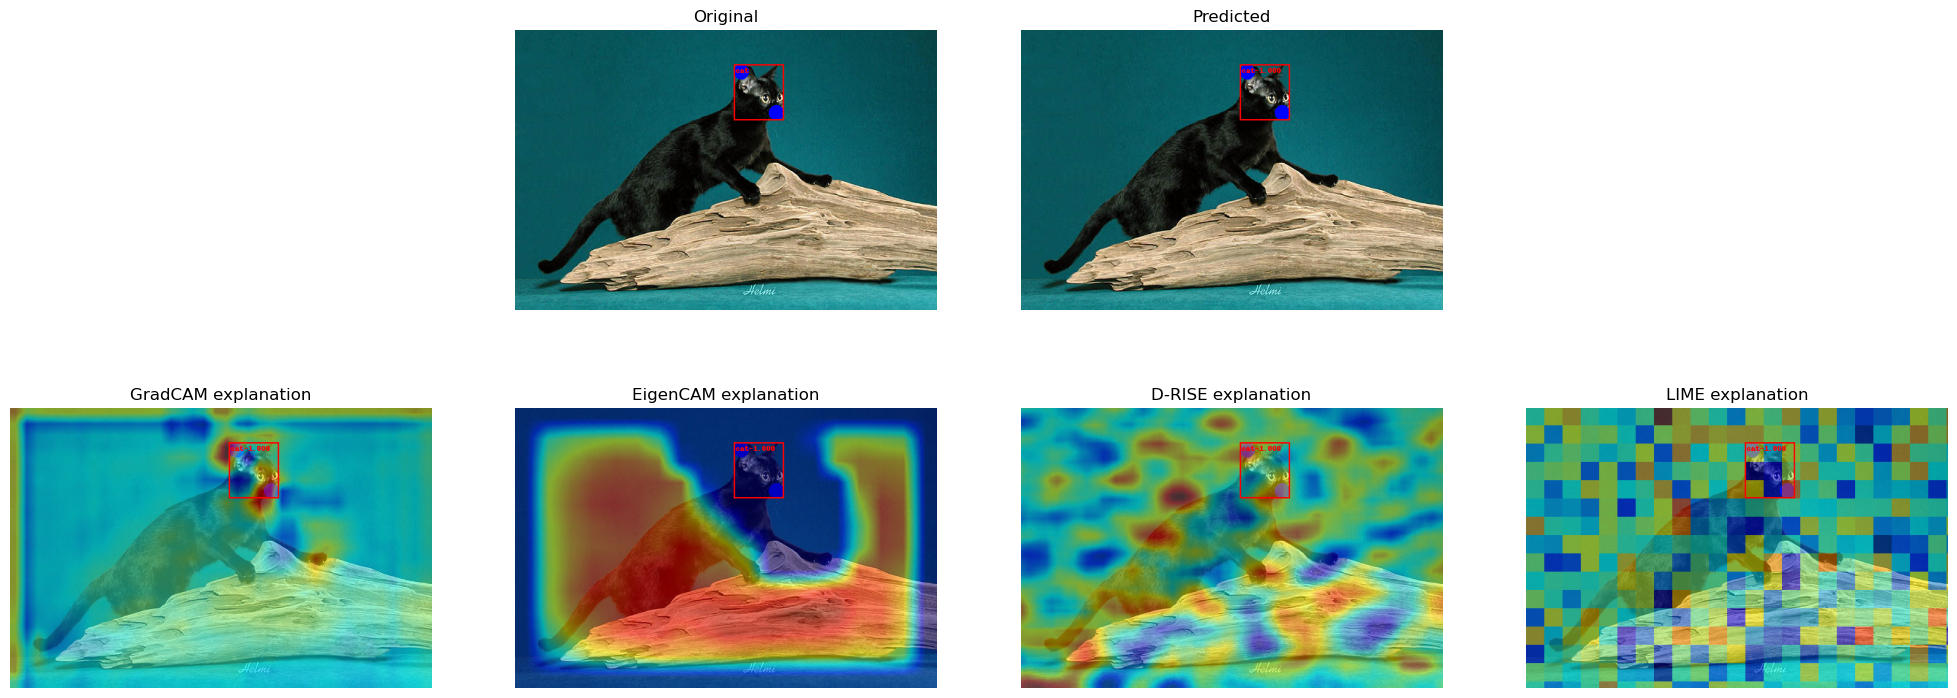

In [12]:
fig, ax = plt.subplots(2, 4, figsize=(25, 9))

ax[0][0].axis('off')
ax[0][3].axis('off')

imshow_with_box(
    img=img,
    boxes=targets['boxes'],
    labels=[train_dataset.classes[i] for i in targets['labels']],
    colors='red',
    width=2,
    ax=ax[0][1]
)
ax[0][1].axis('off')
ax[0][1].set_title('Original')

imshow_with_box(
    img=img,
    boxes=pred['boxes'],
    labels=[f'{train_dataset.classes[i]}-{score:.3f}' for i, score in zip(pred['labels'], pred['scores'])],
    colors='red',
    width=2,
    ax=ax[0][2]
)
ax[0][2].axis('off')
ax[0][2].set_title('Predicted')

imshow_with_box(
    img=torch.tensor(np.moveaxis(gradcam_image, 2, 0))/255,
    boxes=pred['boxes'],
    labels=[f'{train_dataset.classes[i]}-{score:.3f}' for i, score in zip(pred['labels'], pred['scores'])],
    colors='red',
    width=2,
    ax=ax[1][0]
)
ax[1][0].axis('off')
ax[1][0].set_title('GradCAM explanation')

imshow_with_box(
    img=torch.tensor(np.moveaxis(eigencam_image, 2, 0))/255,
    boxes=pred['boxes'],
    labels=[f'{train_dataset.classes[i]}-{score:.3f}' for i, score in zip(pred['labels'], pred['scores'])],
    colors='red',
    width=2,
    ax=ax[1][1]
)
ax[1][1].axis('off')
ax[1][1].set_title('EigenCAM explanation')

imshow_with_box(
    img=torch.tensor(np.moveaxis(d_rise_image, 2, 0))/255,
    boxes=pred['boxes'],
    labels=[f'{train_dataset.classes[i]}-{score:.3f}' for i, score in zip(pred['labels'], pred['scores'])],
    colors='red',
    width=2,
    ax=ax[1][2]
)
ax[1][2].axis('off')
ax[1][2].set_title('D-RISE explanation')

imshow_with_box(
    img=torch.tensor(np.moveaxis(lime_image, 2, 0))/255,
    boxes=pred['boxes'],
    labels=[f'{train_dataset.classes[i]}-{score:.3f}' for i, score in zip(pred['labels'], pred['scores'])],
    colors='red',
    width=2,
    ax=ax[1][3]
)
ax[1][3].axis('off')
ax[1][3].set_title('LIME explanation')

plt.show()